In [1]:
from financiero_3 import *
# import plotly.io as pio
# pio.renderers.default = "notebook"

In [2]:
#Fondo de reserva general
fondo_reserva = fondo_reserva_general()

Última actualización: 30-07-2025
Cantidad del fondo requerida: 4297€


In [3]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.25.0
ipykernel        : 6.28.0
ipywidgets       : 7.8.1
jupyter_client   : 8.6.0
jupyter_core     : 5.7.2
jupyter_server   : 2.14.1
jupyterlab       : 4.0.11
nbclient         : 0.10.2
nbconvert        : 7.10.0
nbformat         : 5.9.2
notebook         : 7.0.8
qtconsole        : not installed
traitlets        : 5.14.3


Saldo total: 21549.46
Cuenta: Metálico, Saldo: 33.01
Cuenta: Ahorro, Saldo: 10440.06
Cuenta: My Investor, Saldo: 10235.68
Cuenta: Cobee, Saldo: -398.7
Cuenta: Revolut, Saldo: -0.0
Cuenta: Amex, Saldo: -502.59
Cuenta: Invertido, Saldo: 1300.0
Cuenta: Principal, Saldo: 442.0
💼 Resumen de ingresos:
24099.66

📉 Gastos personales netos:
categoria
Alimentacion        183.05
Entretenimiento    1723.66
Hosteleria         3618.44
Otros              1701.83
Transporte         2823.17
Name: cantidad, dtype: float64

📅 Resumen mensual:
grupo    ingresos   gastos  balance
mes                                
2024-10   1717.37   730.48   986.89
2024-11   1699.06   626.10  1072.96
2024-12   2921.28   656.92  2264.36
2025-01   1452.31   457.82   994.49
2025-02   1587.22  1054.48   532.74
2025-03   2292.46   670.40  1622.06
2025-04   2232.59   383.10  1849.49
2025-05   1572.41   551.72  1020.69
2025-06   1465.48  1052.28   413.20
2025-07   3387.51   594.77  2792.74
2025-08   1481.71   226.72  1254.99
20

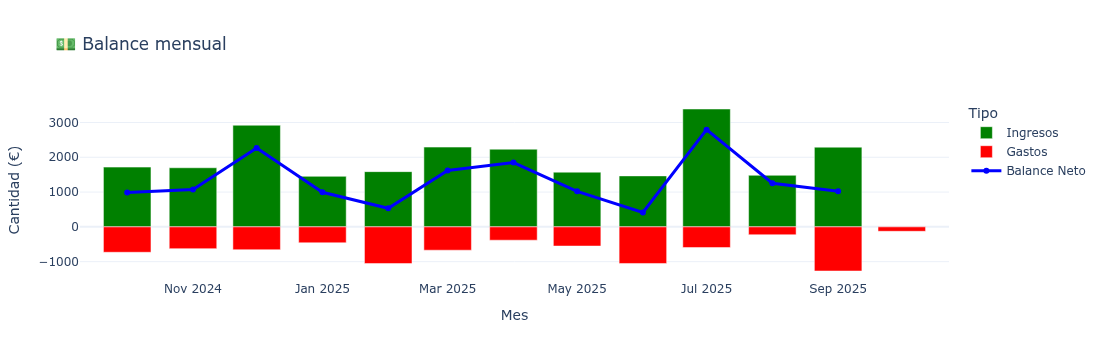

Promedio mensual por categoría:
alimentacion        14.080769
entretenimiento    101.716923
hosteleria         206.920000
otros              129.756154
transporte         193.753846
dtype: float64

Categoría más volátil (desviación estándar):
alimentacion        17.342252
entretenimiento    117.404475
hosteleria         121.712274
otros              121.412823
transporte         194.214689
dtype: float64

Mes con mayor gasto total:
2025-09


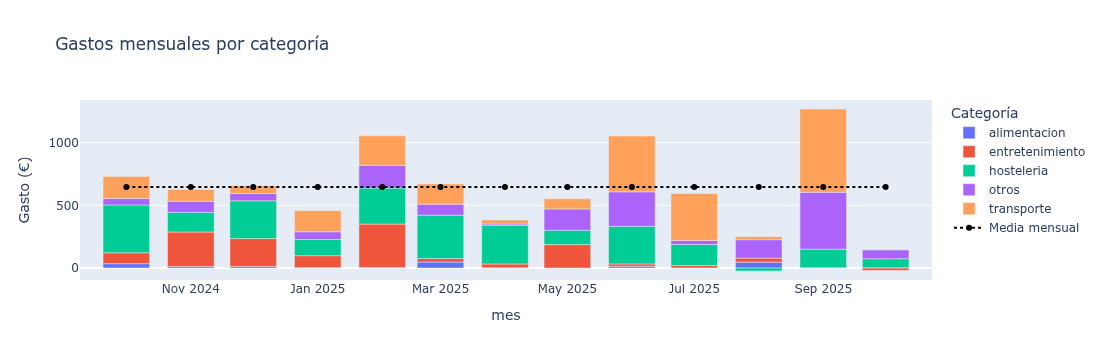

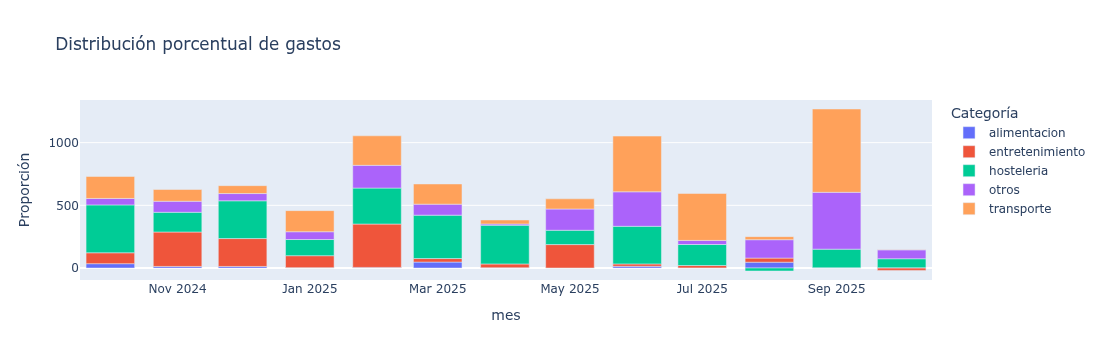

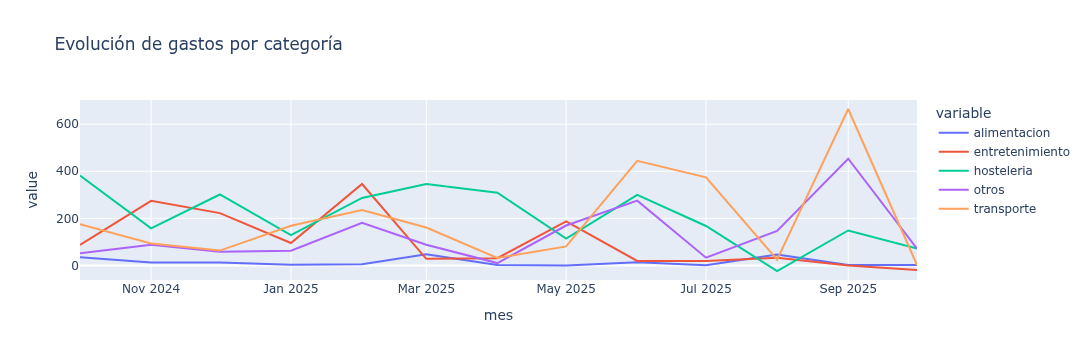

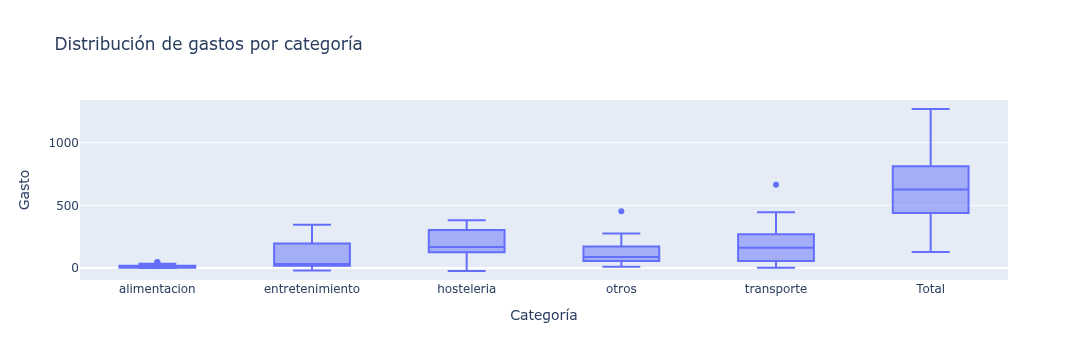

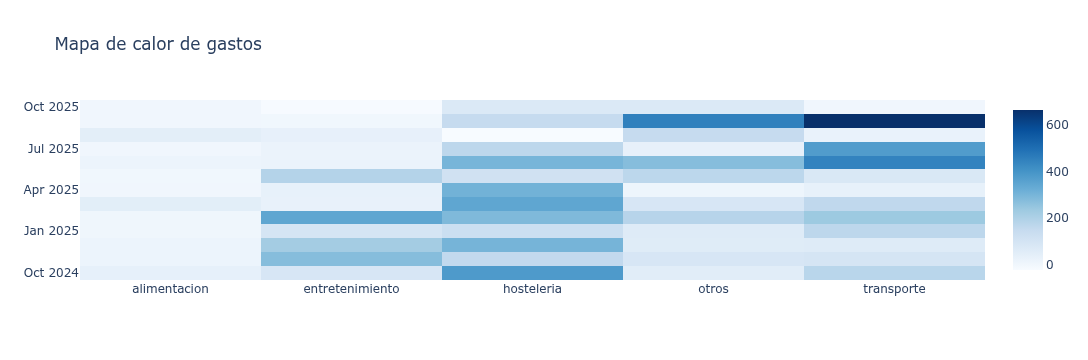


Resumen rápido:
Mes con mayor gasto total: 2025-09 (1268.3600000000001 €)
Mes con menor gasto total: 2025-10 (127.81 €)

% promedio de gasto fijo (alimentación + transporte): 28.1 %


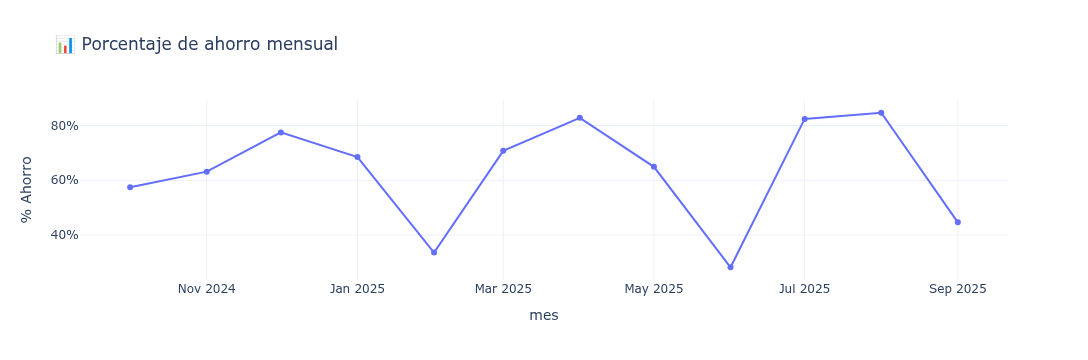

Es posible que los valores no sean precisos para el fondo de reserva, se debe observar cuando se ha obtenido el ingreso de fin de mes.


In [4]:
# Lectura de datos
excel = os.getcwd() + '/Data/Registros/' + "Inicio.xlsx"

gastos = pd.read_excel(excel, sheet_name=0).iloc[:, [0, 1, 2, 3] + [-2, -1]]
ingresos = pd.read_excel(excel, sheet_name=1).iloc[:, [0, 1, 2, 3] + [-2, -1]]
transferencias = pd.read_excel(excel, sheet_name=2).drop(columns=['Cantidad en divisa entrante', 'Divisa saliente', 'Divisa entrante']).iloc[:-1]

gastos.columns = ["fecha", "categoria", "cuenta", "cantidad", "etiquetas", "comentario"]
ingresos.columns = ["fecha", "categoria", "cuenta", "cantidad", "etiquetas", "comentario"]
transferencias.columns = ["fecha", "saliente", "entrante", "cantidad", "comentario"]

gastos['categoria'] = gastos['categoria'].apply(eliminar_tildes)
ingresos['categoria'] = ingresos['categoria'].apply(eliminar_tildes)

ingresos['tipo_logico'] = ingresos.apply(clasificar_ingreso, axis=1)
gastos['tipo_logico'] = gastos.apply(clasificar_ingreso, axis=1)
# Convertir fechas a formato datetime
for df in [gastos, ingresos, transferencias]:
    df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")

# Extraer nombres de cuentas
cuentas = set(gastos['cuenta']).union(ingresos['cuenta']).union(transferencias['saliente']).union(transferencias['entrante'])

# Crear objetos Account
cuentas_obj = {nombre: Account(nombre) for nombre in cuentas}

# Crear presupuesto y añadir cuentas
presupuesto = Budget()
for cuenta in cuentas_obj.values():
    presupuesto.add_account(cuenta)




cargar_saldos_iniciales(presupuesto, cuentas_obj, saldos_iniciales)


# Cargar ingresos (+) y gastos (-)
cargar_transacciones(ingresos, cuentas_obj, presupuesto, signo=1)
cargar_transacciones(gastos, cuentas_obj, presupuesto, signo=-1)

for _, fila in transferencias.iterrows():
    fecha = fila['fecha']
    cantidad = fila['cantidad']
    comentario = str(fila['comentario'])

    cuenta_origen = cuentas_obj[fila['saliente']]
    cuenta_destino = cuentas_obj[fila['entrante']]

    trans_salida = Transaction(
        amount=-cantidad,
        description=f"[TRANSFERENCIA SALIENTE] {comentario}",
        category="Transferencia",
        account=cuenta_origen,
        timestamp=fecha
    )

    trans_entrada = Transaction(
        amount=cantidad,
        description=f"[TRANSFERENCIA ENTRANTE] {comentario}",
        category="Transferencia",
        account=cuenta_destino,
        timestamp=fecha
    )

    presupuesto.add_transaction(trans_salida)
    presupuesto.add_transaction(trans_entrada)


print("Saldo total:", presupuesto.get_balance())

for nombre, cuenta in cuentas_obj.items():
    print(f"Cuenta: {nombre}, Saldo: {round(cuenta.balance,2)}")

ingresos = procesar_ingresos(ingresos)

print("💼 Resumen de ingresos:")
print(resumen_ingresos(ingresos))

print("\n📉 Gastos personales netos:")
print(calcular_gastos_netos(gastos, ingresos))

print("\n📅 Resumen mensual:")
print(resumen_mensual(gastos, ingresos))

# Procesar y calcular
ingresos = procesar_ingresos(ingresos)
gastos_netos = calcular_gastos_netos(gastos, ingresos)
resumen = resumen_mensual(gastos, ingresos)

# Visualizaciones
plot_balance_mensual(resumen)
plot_explicacion_gastos(gastos,ingresos)

# Porcentaje de ahorro
plot_porcentaje_ahorro(gastos, ingresos)


objetivos_config = cargar_objetivos_vista()
historial = crear_historial_cuentas_virtuales(ingresos, gastos, presupuesto, porcentaje_gasto=0.3, objetivos_config=objetivos_config)
historial


objetivos_config_df = pd.DataFrame([
    {
        "Objetivo": cfg["nombre"],
        "Inicio": str(cfg.get("mes_inicio")) if cfg.get("mes_inicio") else "—",
        "Porcentaje ingreso (%)": round(cfg["porcentaje_ingreso"] * 100, 2),
        "Saldo inicial": cfg["saldo_inicial"],
        "Objetivo total": cfg.get("objetivo_total"),
        "Horizonte (meses)": cfg.get("horizonte_meses"),
    }
    for cfg in objetivos_config
])

objetivos_config_df

columnas_objetivos = [
    col for col in historial.columns 
    if col.startswith("🎯 ") or col.startswith("% Objetivo ")
]

if columnas_objetivos:
    historial[["Mes"] + columnas_objetivos].tail()
else:
    print("No hay objetivos vista configurados.")


In [5]:
historial

,Mes,Regalos,Vacaciones,Inversiones,Dinero Invertido,Ahorros,Fondo de reserva cargado,total,Gasto del mes,Presupuesto Mes,Presupuesto Disponible,Deuda Presupuestaria mensual,Deuda Presupuestaria acumulada,Objetivo Ropa,% Objetivo Ropa,Objetivo Coche,% Objetivo Coche
0,2024-10,0.0,55.00,0.00,0.0,6150.88,0.0000,6205.88,730.48,0.00,0,730.48,730.48,0.00,0.00,0.00,0.00
1,2024-11,0.0,95.00,100.30,0.0,7116.54,107.2960,7419.14,626.10,515.21,0,110.89,841.37,0.00,0.00,0.00,0.00
2,2024-12,0.0,135.00,100.59,0.0,9154.47,333.7320,9723.79,656.92,509.72,0,147.20,988.57,0.00,0.00,0.00,0.00
3,2025-01,0.0,505.00,100.93,0.0,10049.51,433.1810,11088.62,457.82,876.38,0,0.00,570.01,0.00,0.00,0.00,0.00
4,2025-02,0.0,585.00,102.55,0.0,10490.45,482.1750,11660.18,1097.28,435.69,0,661.59,1231.59,0.00,0.00,0.00,0.00
5,2025-03,0.0,635.00,264.76,0.0,11950.31,644.3810,13494.45,670.40,476.17,0,194.23,1425.83,0.00,0.00,0.00,0.00
6,2025-04,0.0,635.00,269.94,0.0,13435.75,809.4300,15150.12,582.10,687.74,0,0.00,1320.19,0.00,0.00,0.00,0.00
7,2025-05,0.0,705.00,610.14,0.0,14212.85,895.7749,16423.77,551.72,669.78,0,0.00,1202.13,0.00,0.00,0.00,0.00
8,2025-06,300.0,672.66,791.96,0.0,14452.84,922.4401,17139.90,1052.28,471.72,0,580.56,1782.69,0.00,0.00,0.00,0.00
9,2025-07,315.0,412.75,1135.97,0.0,16417.53,1140.7389,19692.99,594.77,439.64,0,155.13,1937.82,0.00,0.00,271.00,27.10


In [6]:
cargar_objetivos_vista()

[{'nombre': 'Ropa',
  'etiquetas': ['ropa'],
  'porcentaje_ingreso': 0.02,
  'saldo_inicial': 0.0,
  'objetivo_total': 300.0,
  'horizonte_meses': 12,
  'mes_inicio': Period('2025-08', 'M')},
 {'nombre': 'Coche',
  'etiquetas': ['coche'],
  'porcentaje_ingreso': 0.08,
  'saldo_inicial': 0.0,
  'objetivo_total': 1000.0,
  'horizonte_meses': 12,
  'mes_inicio': Period('2025-07', 'M')}]

### Gestión interactiva de objetivos vista

Usa el gestor para añadir, editar o eliminar sobres.  
Recuerda pulsar **Guardar en disco** para persistir los cambios en `Data/objetivos_vista.json`.


In [7]:
gestor_objetivos = crear_widget_gestor_objetivos()
gestor_objetivos


In [8]:
objetivos_config_df

,Objetivo,Inicio,Porcentaje ingreso (%),Saldo inicial,Objetivo total,Horizonte (meses)
0,Ropa,2025-08,2.0,0.0,300.0,12
1,Coche,2025-07,8.0,0.0,1000.0,12


In [9]:
21644.3-20494.30	

1150.0

In [10]:
resumen_global(presupuesto, "2025-09-30")

💰 Saldo total al 2025-09-30: 21644.3
Saldos al 2025-09-30:
Cuenta: Metálico, Saldo: 23.01
Cuenta: Ahorro, Saldo: 10595.64
Cuenta: My Investor, Saldo: 10372.71
Cuenta: Cobee, Saldo: -299.71
Cuenta: Revolut, Saldo: -0.0
Cuenta: Amex, Saldo: -586.82
Cuenta: Invertido, Saldo: 1150.0
Cuenta: Principal, Saldo: 389.47


In [11]:
presupuesto

<Budget: 8 cuentas, 779 transacciones>

In [12]:
presupuesto.balances_a_fecha(pd.to_datetime("2025-08-30"))["Invertido"]

0

/home/alex/anaconda3/envs/gestiones/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/alex/anaconda3/envs/gestiones/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/alex/anaconda3/envs/gestiones/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



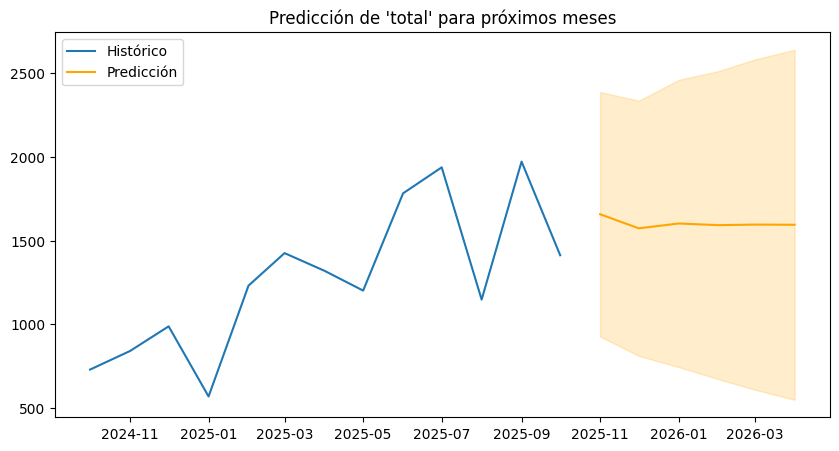

2025-11-01    1657.811202
2025-12-01    1573.845721
2026-01-01    1602.627788
2026-02-01    1592.761741
2026-03-01    1596.143669
2026-04-01    1594.984397
Freq: MS, Name: predicted_mean, dtype: float64


In [13]:
predecir_total(historial, 'Deuda Presupuestaria acumulada')

💡 Dinero restante este mes: 559.27
👉 Puedes gastar aproximadamente 559.27 por semana durante las 1 semanas restantes de 2025-10.


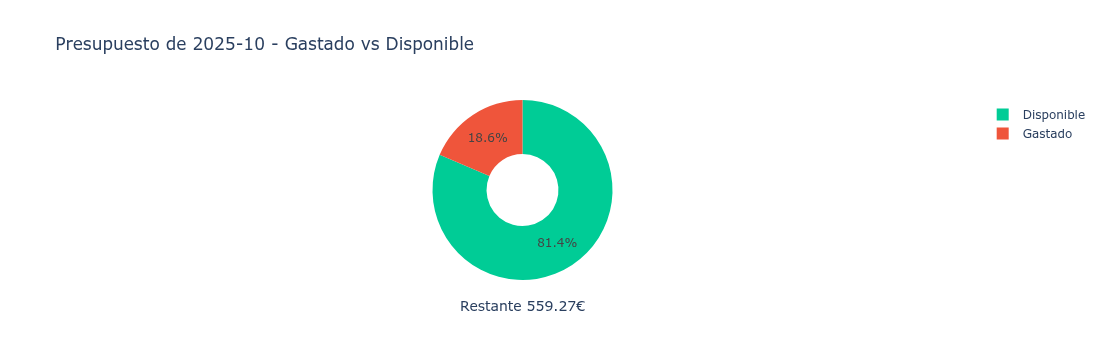

In [14]:
grafico_presupuesto(historial)

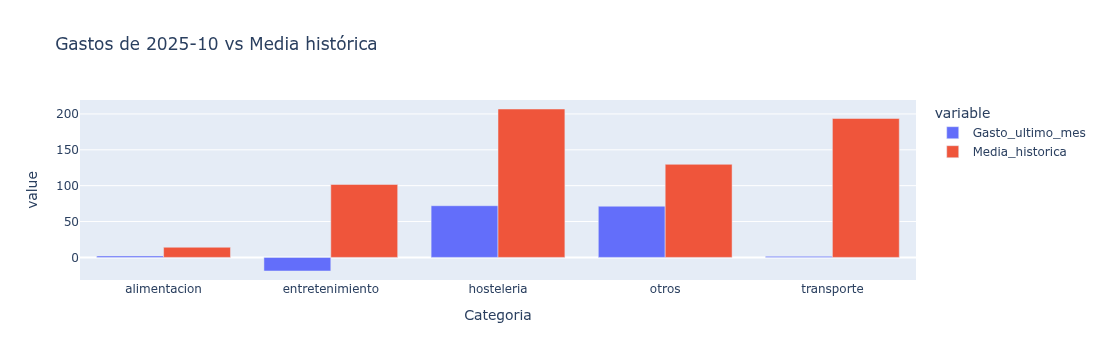

,Categoria,Gasto_ultimo_mes,Media_historica,Diferencia
0,alimentacion,2.00,14.080769,12.080769
1,entretenimiento,-19.00,101.716923,120.716923
2,hosteleria,72.04,206.920000,134.880000
3,otros,71.35,129.756154,58.406154
4,transporte,1.42,193.753846,192.333846


In [15]:
graficar_gasto_vs_media(gastos, ingresos)

In [16]:
# ultimo_mes = df_resumen['Mes'].max().to_period('M')
pd.Timestamp.today().to_period('M')

Period('2025-10', 'M')